In [5]:
import os
from datetime import datetime
import gdown
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

In [6]:
df = pd.read_csv('/content/Horserace_ML.csv')

In [7]:
df.columns

Index(['age', 'trainerName', 'jockeyName', 'course', 'weight', 'TR', 'isFav',
       'runners', 'res_place', 'position', 'distance_in_miles'],
      dtype='object')

In [8]:
#Splitting to keep the test set aside
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
train_subset = train_set.sample(n=150000, random_state=42)

In [10]:
df2 = train_subset.copy()

# Evaluation Function

In [11]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R2 Score:", r2)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.show()

In [12]:
# Define features and target variable for the subset
X_subset = df2.drop(columns=['position'])
y_subset = df2['position']

# Splitting the subset data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)


In [13]:
# Label Encoding for categorical features
categorical_columns = ['trainerName', 'jockeyName','course']
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X_train[col] = label_encoders[col].fit_transform(X_train[col])
    X_test[col] = label_encoders[col].transform(X_test[col])

#  Standard Scaling for numerical features
numerical_columns = ['age','weight','TR','runners', 'distance_in_miles']
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])


# Label Encoding for target in the subset
label_encoder_y = LabelEncoder()
y_train_encoded = label_encoder_y.fit_transform(y_train)
y_test_encoded = label_encoder_y.transform(y_test)

In [14]:
#  Apply SMOTE to handle class imbalance (if needed)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_encoded)

In [15]:
#Recursive Feature Elimination (RFE)
base_model = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8, step=1)
rfe.fit(X_train_balanced, y_train_balanced)

# Get selected features by RFE
selected_features = X_train.columns[rfe.support_].tolist()
print("Selected Features by RFE:", selected_features)

Selected Features by RFE: ['age', 'trainerName', 'course', 'weight', 'TR', 'runners', 'res_place', 'distance_in_miles']


In [16]:
# Selecting features for training from balanced data
X_train_selected = X_train_balanced[selected_features]
X_test_selected = X_test[selected_features]


Decision Tree Regressor:
Mean Squared Error: 8.201521311382017
Mean Absolute Error: 2.0963225241578245
R2 Score: 0.600005233440586


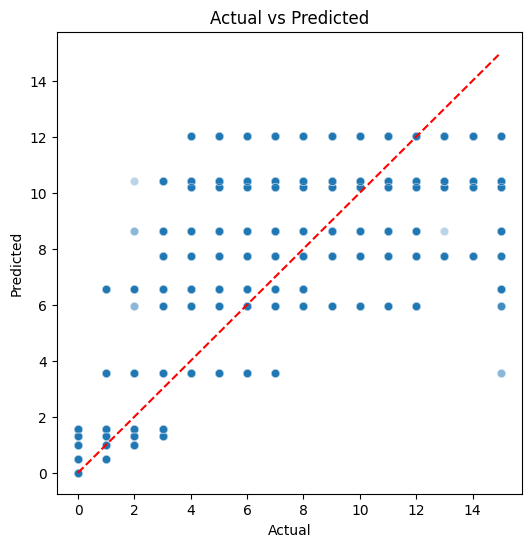

In [17]:
print("\nDecision Tree Regressor:")
dt_regressor = DecisionTreeRegressor(max_depth=4, random_state=42)
evaluate_model(dt_regressor, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)



Random Forest Regressor:
Mean Squared Error: 7.005661587706018
Mean Absolute Error: 1.9219109686394027
R2 Score: 0.658328270453945


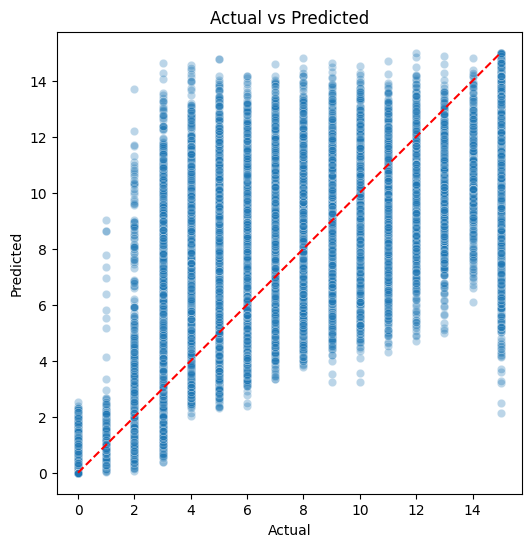

In [18]:
# Random Forest Regressor
print("\nRandom Forest Regressor:")
rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)
evaluate_model(rf_regressor, X_train_selected, X_test_selected,  y_train_balanced, y_test_encoded)


Gradient Boosting Regressor:
Mean Squared Error: 6.794270513751204
Mean Absolute Error: 1.9267121875946478
R2 Score: 0.6686379825267472


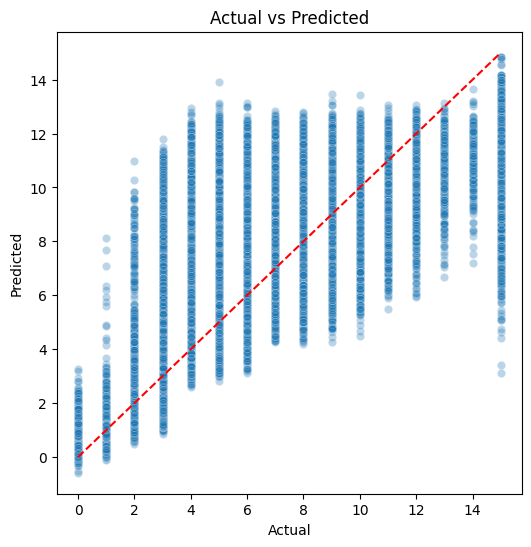

In [19]:
# Gradient Boosting Regressor
print("\nGradient Boosting Regressor:")
gb_regressor = GradientBoostingRegressor(random_state=42)
evaluate_model(gb_regressor, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)



XGBoost Regressor:
Mean Squared Error: 6.512922763824463
Mean Absolute Error: 1.8874964714050293
R2 Score: 0.682359516620636


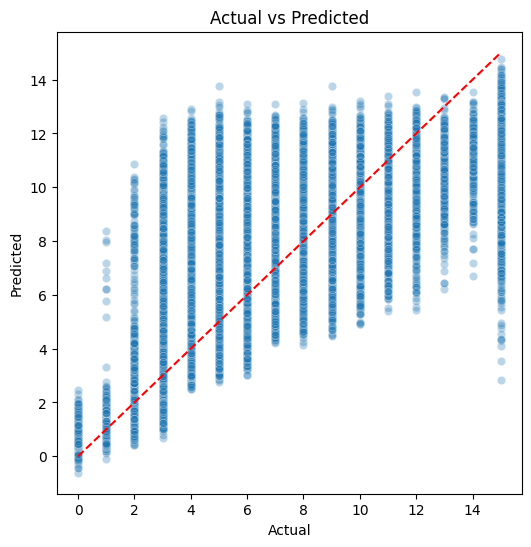

In [20]:
# XGBoost Regressor
print("\nXGBoost Regressor:")
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
evaluate_model(xgb_regressor, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)



K-Nearest Neighbors Regressor:
Mean Squared Error: 12.438382666666666
Mean Absolute Error: 2.7247
R2 Score: 0.39337010997882516


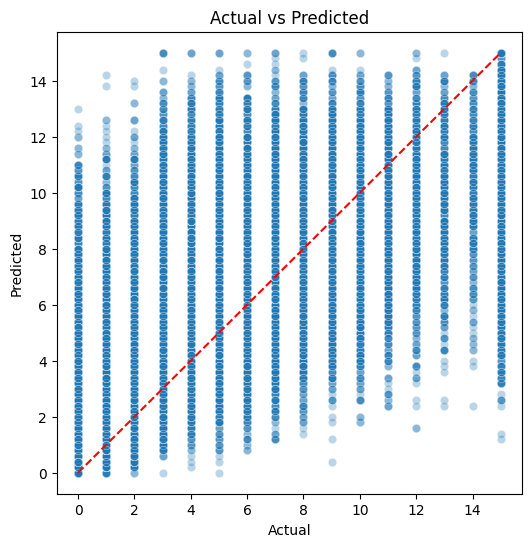

In [21]:

# K-Nearest Neighbors Regressor
print("\nK-Nearest Neighbors Regressor:")
knn_regressor = KNeighborsRegressor(n_neighbors=5)
evaluate_model(knn_regressor, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)



LightGBM Regressor:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 187840, number of used features: 8
[LightGBM] [Info] Start training from score 7.500000
Mean Squared Error: 6.399245667426573
Mean Absolute Error: 1.8718756344314214
R2 Score: 0.687903660831028


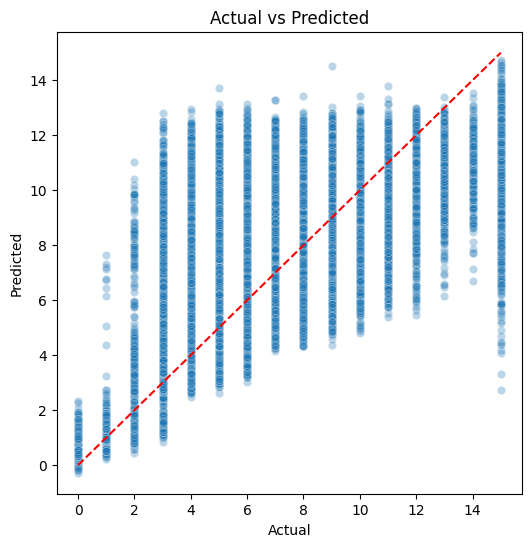

In [22]:
# LightGBM Regressor
print("\nLightGBM Regressor:")
lgb_regressor = LGBMRegressor(random_state=42)
evaluate_model(lgb_regressor, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)




CatBoost Regressor:
Mean Squared Error: 6.270548073865753
Mean Absolute Error: 1.848801280819681
R2 Score: 0.6941803455994596


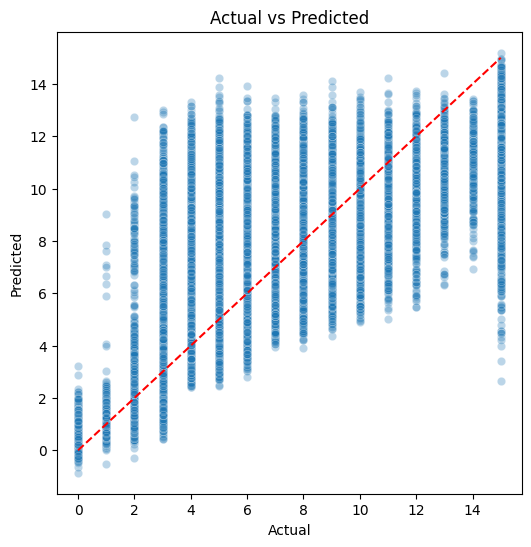

In [23]:
# CatBoost Regressor
print("\nCatBoost Regressor:")
cat_regressor = CatBoostRegressor(random_state=42, verbose=0)
evaluate_model(cat_regressor, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters for CatBoost: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 8, 'border_count': 200}
Mean Squared Error: 6.906072735499501
Mean Absolute Error: 1.9690107842639728
R2 Score: 0.6631852985805419


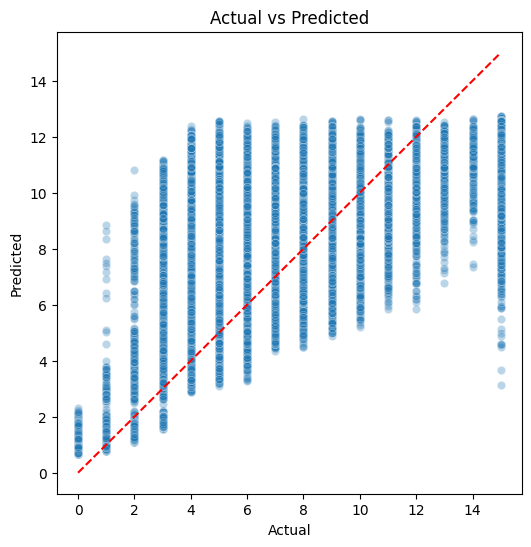

In [24]:


# Define the parameter grid for CatBoost
param_grid_catboost = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 50, 100, 200]
}

# Initialize the CatBoost Regressor
catboost_regressor = CatBoostRegressor(loss_function='RMSE', random_seed=42, silent=True)

# Initialize RandomizedSearchCV
random_search_catboost = RandomizedSearchCV(
    estimator=catboost_regressor,
    param_distributions=param_grid_catboost,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search_catboost.fit(X_train_selected, y_train_balanced)

# Best parameters
print("Best Parameters for CatBoost:", random_search_catboost.best_params_)

# Best estimator
best_catboost_model = random_search_catboost.best_estimator_

# Evaluate the best CatBoost model
evaluate_model(best_catboost_model, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
54 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best Parameters for Gradient Boosting: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 4, 'learning_rate': 0.05}
Mean Squared Error: 6.787067500001491
Mean Absolute Error: 1.927647093389691
R2 Score: 0.6689892792793806


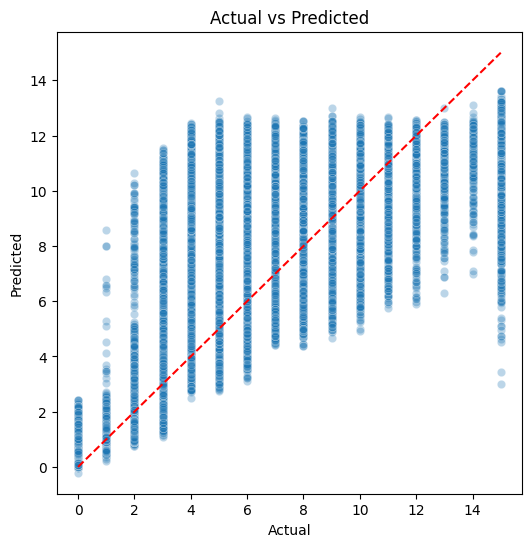

In [25]:

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    estimator=gb_regressor,
    param_distributions=param_grid_gb,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search_gb.fit(X_train_selected, y_train_balanced)

# Best parameters
print("Best Parameters for Gradient Boosting:", random_search_gb.best_params_)

# Best estimator
best_gb_model = random_search_gb.best_estimator_

# Evaluate the best Gradient Boosting model
evaluate_model(best_gb_model, X_train_selected, X_test_selected, y_train_balanced, y_test_encoded)


In [26]:
best_gb_model

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=2,
                          min_samples_split=10, random_state=42)

# Training Full data

In [27]:
# Define features and target variable for the full train set
X_train_full = train_set.drop(columns=['position'])
y_train_full = train_set['position']

# Initialize encoders
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X_train_full[col] = label_encoders[col].fit_transform(X_train_full[col])



In [28]:
# Standard Scaling for numerical features
scaler = StandardScaler()
X_train_full[numerical_columns] = scaler.fit_transform(X_train_full[numerical_columns])

# Label Encoding for target variable
label_encoder_y = LabelEncoder()
y_train_full_encoded = label_encoder_y.fit_transform(y_train_full)



In [29]:
# Apply SMOTE to handle class imbalance (if needed)
smote = SMOTE(random_state=42)
X_train_full_balanced, y_train_full_balanced = smote.fit_resample(X_train_full, y_train_full_encoded)



In [30]:
# Feature selection with RFE using the full balanced dataset
base_model = XGBRegressor(random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8, step=1)
rfe.fit(X_train_full_balanced, y_train_full_balanced)

# Get selected features by RFE
selected_features_full = X_train_full.columns[rfe.support_].tolist()
X_train_selected_full = X_train_full_balanced[selected_features_full]


In [31]:
# Retrieve best estimator from RandomizedSearchCV
best_gb_model = random_search_gb.best_estimator_

# Train the best XGBRegressor model on the full balanced dataset
best_gb_model.fit(X_train_selected_full, y_train_full_balanced)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=2,
                          min_samples_split=10, random_state=42)

In [32]:
# Prepare test set for evaluation
X_test = test_set.drop(columns=['position'])
y_test = test_set['position']

# Transform categorical features in X_test using fitted encoders
for col in categorical_columns:
    X_test[col] = label_encoders[col].transform(X_test[col])

# Standard Scaling for numerical features on test set
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Selecting features for test set from balanced data
X_test_selected = X_test[selected_features_full]

# Evaluate the best XGBRegressor model on the test set
y_pred = best_gb_model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

# Optionally, you can also print the selected features by RFE
print("Selected Features by RFE:", selected_features_full)

Mean Squared Error: 7.347548356359635
Mean Absolute Error: 2.0527368786157805
R2 Score: 0.6451005952729352
Selected Features by RFE: ['age', 'course', 'weight', 'TR', 'isFav', 'runners', 'res_place', 'distance_in_miles']


In [33]:
import joblib

# Save the model
joblib.dump(best_gb_model, 'horse_race_prediction_model.pkl')

['horse_race_prediction_model.pkl']